### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *
from analysis.plot_utils import *
import pandas as pd
from datasets import load_dataset
from collections import Counter

In [2]:
all_df = prepare_df()

# Add the debate leak check
checks_df = load_all_records_into_df('debate_checks').drop_duplicates(['run_id_debate_checks', 'record_id_debate_checks'], keep='last')
all_df = all_df.merge(checks_df, left_on=['debate_run_id_verdicts', 'record_id_verdicts'], right_on=['run_id_debate_checks', 'record_id_debate_checks'], how='left')

### 2 vs 4 choice

In [3]:
verdict_ids_2_choice_gpqa =  ['o6nh196', 'se5tc1t', 'okcg9s1', 'px68tl7', 'gt5hbbc', 'omurjjz', '2ayhhpd', '7ir6j2d', 'mr8lipz', 'kn8lecm', 'k26y5y6', 'uopuf76', 'hmsolpd', 'wvubqq5', '0q341gz', 'm6zo8vx', 'jgrph0e']
verdict_ids_4_choice_gpqa =  ['2bmbqk1', 'po3v9oq', 'qx50tbo', 'jm9kod3', '4rg7b4b', 'faqmo5o', 'dph0qre', '9jiz6cv', 'p8zeu0p', 'ouuwuug', 'yt32eoi', 'vwmy4y3', 'qiqr2wo', '2pvnm1z', 'ujzubt9', '4ukh5h7', '3oxc0v3']

verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids_2_choice_gpqa + verdict_ids_4_choice_gpqa)]

# optionally, only keep records that don't have a leak
verdicts_df = verdicts_df[verdicts_df['has_leak_debate_checks'] == False]

# optionally, only keep recordsthat appear in both 2 and 4 choice
verdicts_df = verdicts_df[verdicts_df.groupby(['config_judge_model_verdicts', 'question_idx_debates']).transform('size')==2].reset_index(drop=True)
# optionally, only keep records (questions) that appear in every run (or adjust to >= tot_runs - x to make more lenient)
# tot_runs = len(verdict_ids_2_choice_gpqa + verdict_ids_4_choice_gpqa) 
# verdicts_df = verdicts_df[verdicts_df.groupby(['question_idx_debates']).transform('size') >= tot_runs].reset_index(drop=True)  # 

df_2_choice_gpqa = verdicts_df[verdicts_df['verdict_run_id_verdicts'].isin(verdict_ids_2_choice_gpqa)]
df_4_choice_gpqa = verdicts_df[verdicts_df['verdict_run_id_verdicts'].isin(verdict_ids_4_choice_gpqa)]

acc_2_choice_gpqa = aggregate_by_fields(df_2_choice_gpqa, ['config_judge_model_verdicts'])
acc_4_choice_gpqa = aggregate_by_fields(df_4_choice_gpqa, ['config_judge_model_verdicts'])

print(df_2_choice_gpqa.shape, df_4_choice_gpqa.shape)

(1701, 87) (1701, 87)


/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:145: RuntimeWarning: invalid value encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


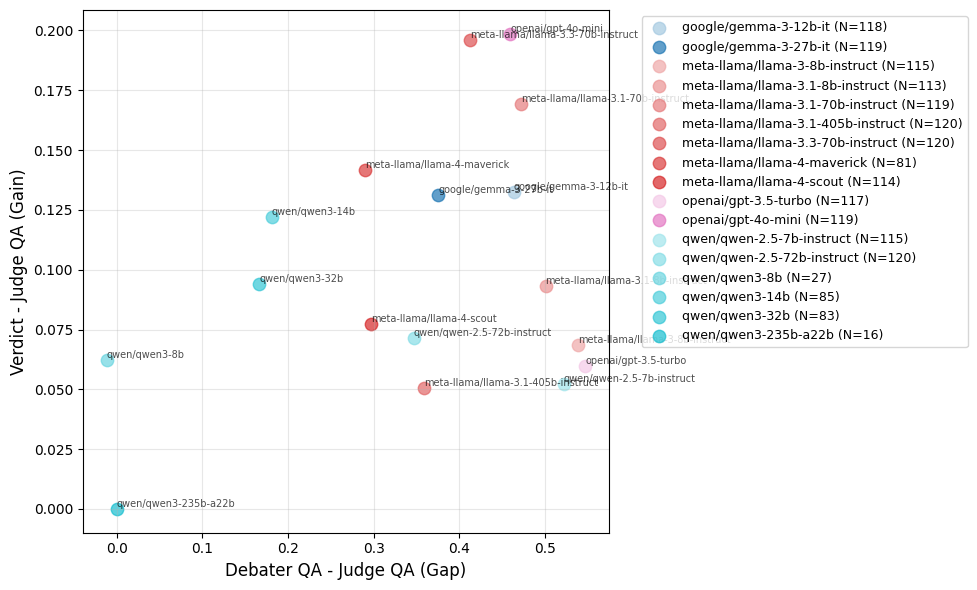

In [4]:
results_df = acc_4_choice_gpqa
# results_df = results_df[results_df['n_total'] > 45]
plot_gain_scatter(results_df, n_choices=4, over='gap') # or over=judge_qa

(<module 'matplotlib.pyplot' from '/Users/joshlevy/.pyenv/versions/3.11.13/envs/llm_judge_debate_NEW_env/lib/python3.11/site-packages/matplotlib/pyplot.py'>,
 <Axes: xlabel='Judge Model', ylabel='Gain'>,
 <Axes: xlabel='Judge Model', ylabel='Gap'>)

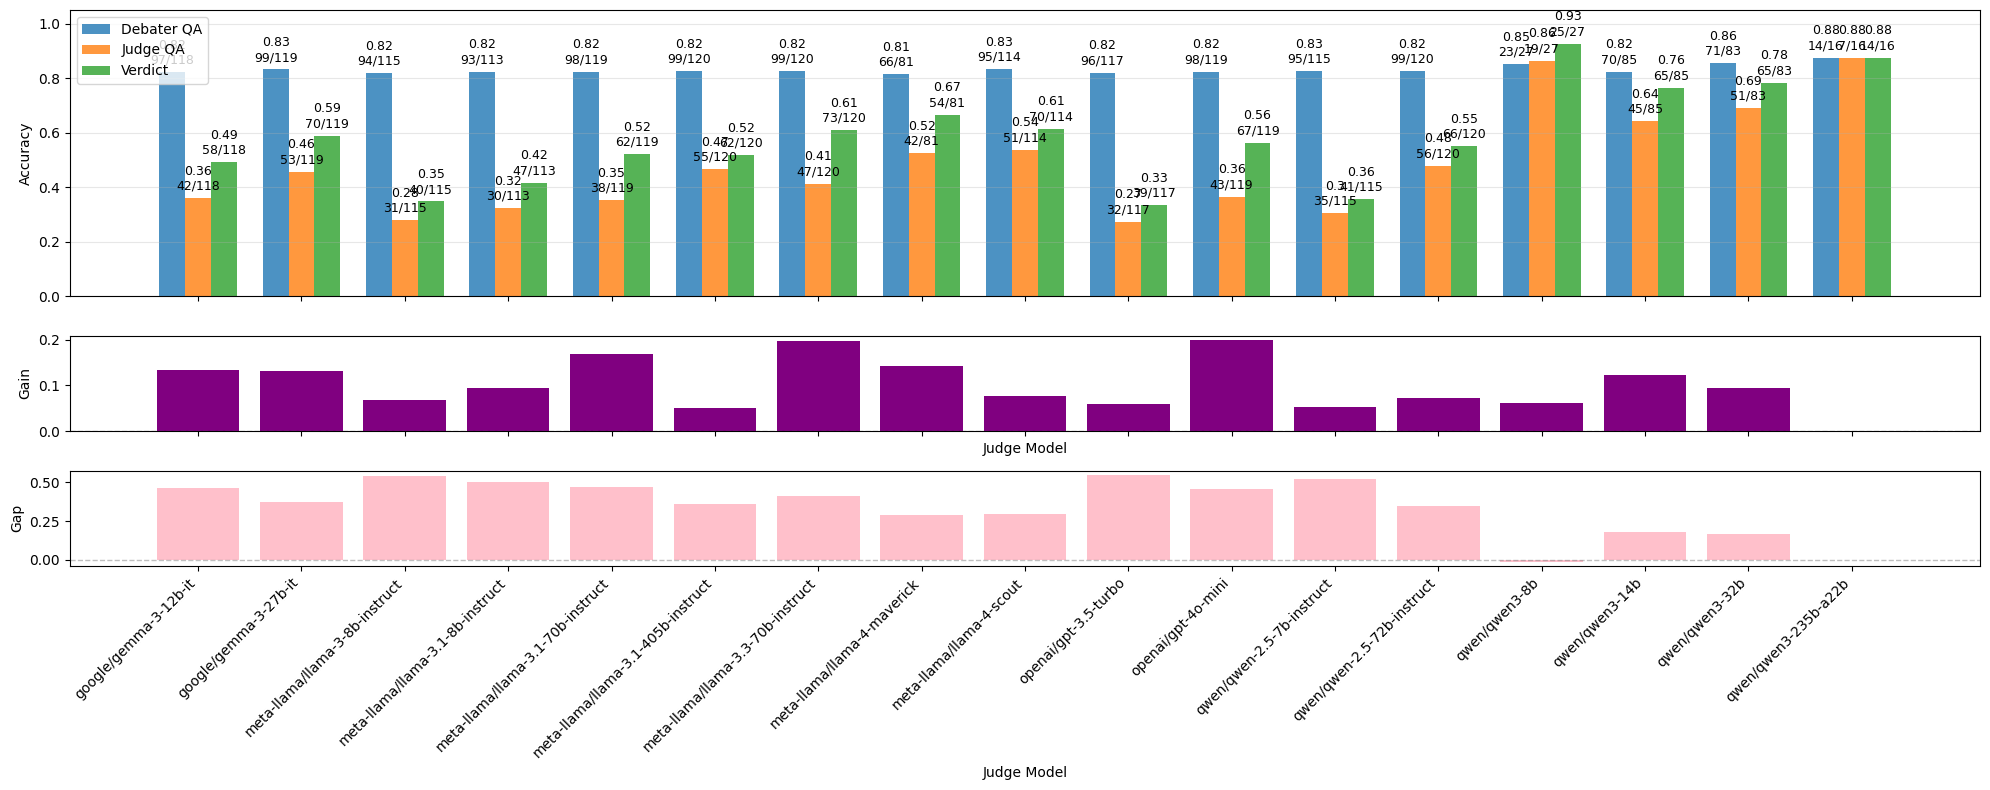

In [5]:
plot_results_by_name(acc_4_choice_gpqa)

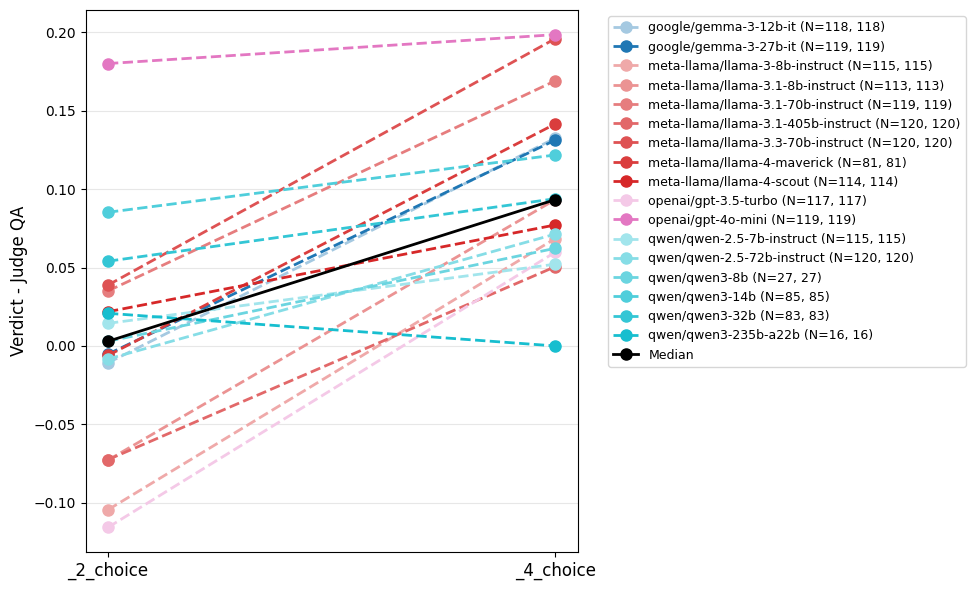

In [6]:
suffixes = ['_2_choice', '_4_choice']
merged_choice = acc_2_choice_gpqa.merge(acc_4_choice_gpqa, on='name', suffixes=suffixes)

plot_spaghetti(merged_choice, suffixes)

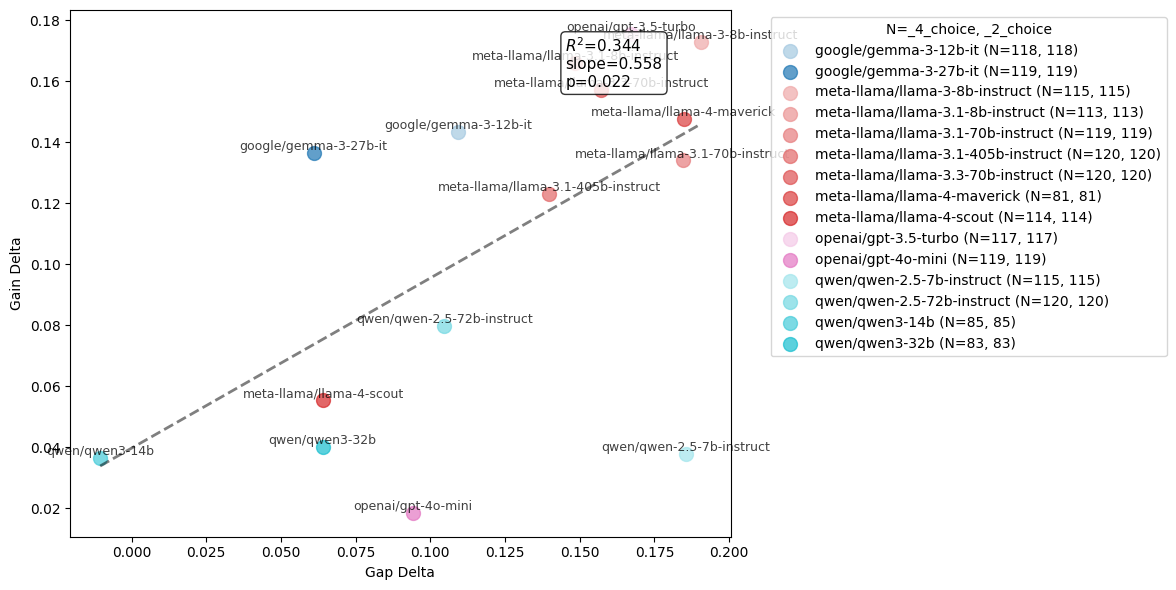

In [7]:
suffixes = ['_4_choice', '_2_choice']

temp = merged_choice[(merged_choice[f'n_total{suffixes[0]}'] > 45) & (merged_choice[f'n_total{suffixes[1]}'] > 45)]
plot_delta_over_delta(temp, suffixes, xfield='gap_delta', yfield='gain_delta', n_min=20)

### Chemistry vs Physics

In [8]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)

In [9]:
# temp_df = verdicts_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))
temp_df = df_4_choice_gpqa.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))
# temp_df = df_2_choice_gpqa.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))


chemistry_df = temp_df[temp_df['high_level_domain'] == 'Chemistry']
physics_df = temp_df[temp_df['high_level_domain'] == 'Physics']

chemistry_gpqa_acc = aggregate_by_fields(chemistry_df, ['config_judge_model_verdicts'])
physics_gpqa_acc = aggregate_by_fields(physics_df, ['config_judge_model_verdicts'])

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),
/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/../analysis/analysis_utils.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  'pgr': (df['is_correct_verdict'].mean() - df['is_correct_qa_judge'].mean()) / (df['is_correct_qa_debater'].mean() - df['is_correct_qa_judge'].mean()),


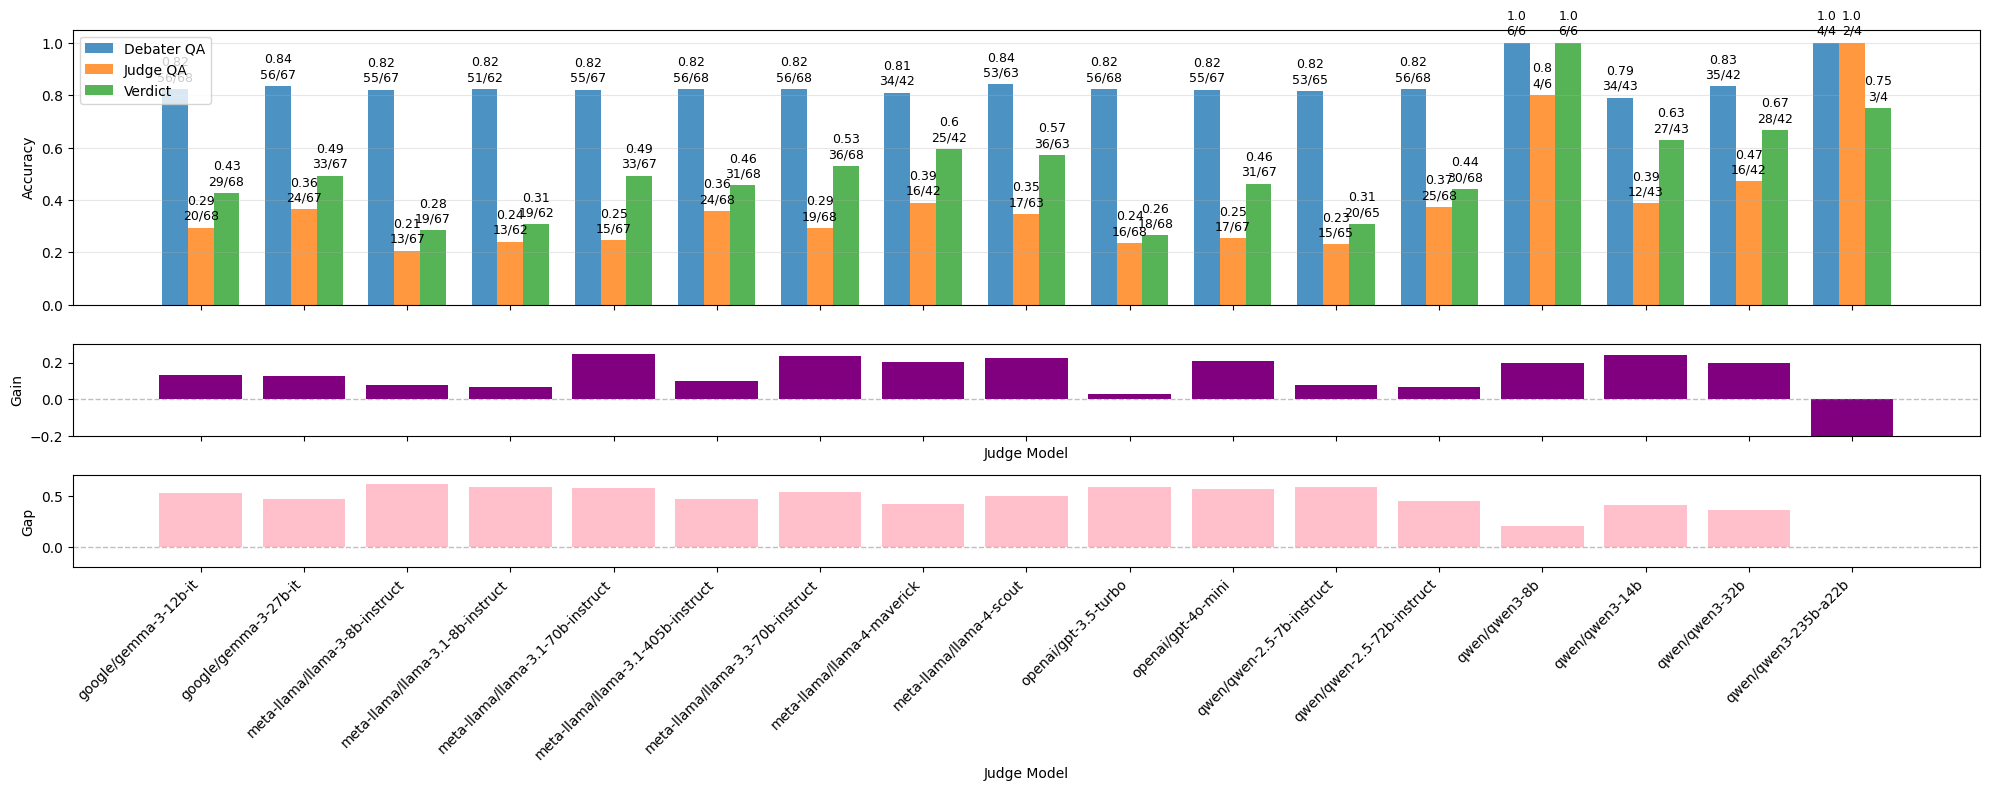

In [10]:
plt, ax_gain, ax_gap = plot_results_by_name(chemistry_gpqa_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

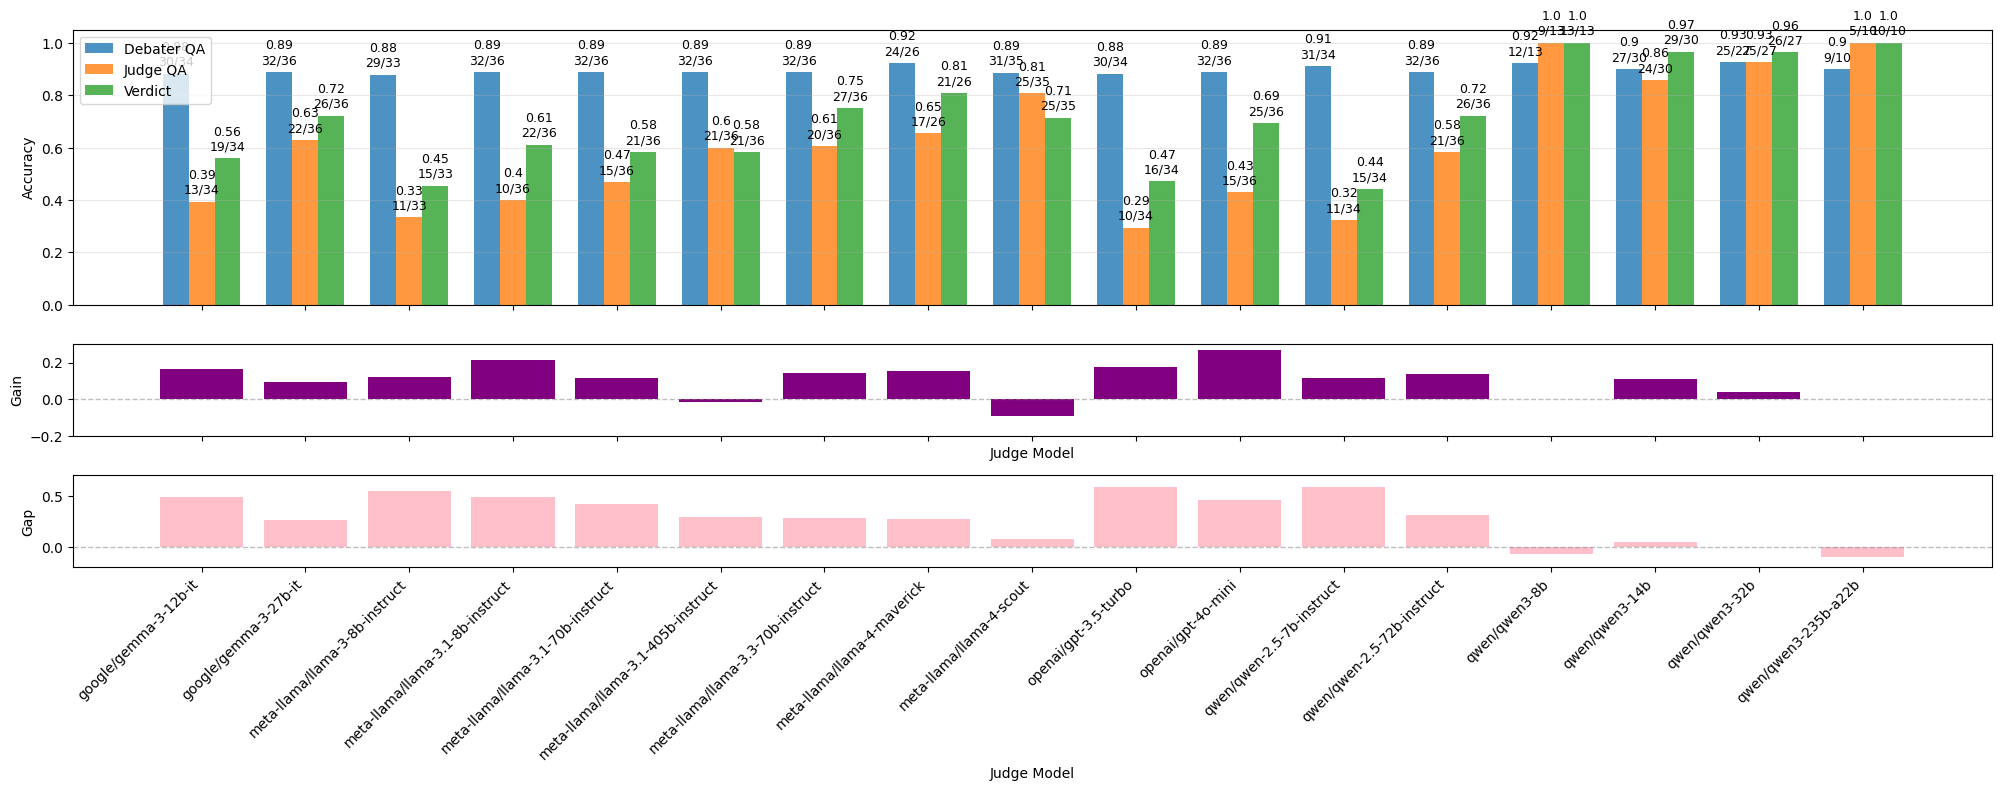

In [11]:
plt, ax_gain, ax_gap = plot_results_by_name(physics_gpqa_acc)
ax_gain.set_ylim([-.2, .3])
ax_gap.set_ylim([-.2, .7])
plt.show()

skipping qwen/qwen3-8b because too few samples: n_0 = 6 and n_1 = 13
skipping qwen/qwen3-235b-a22b because too few samples: n_0 = 4 and n_1 = 10


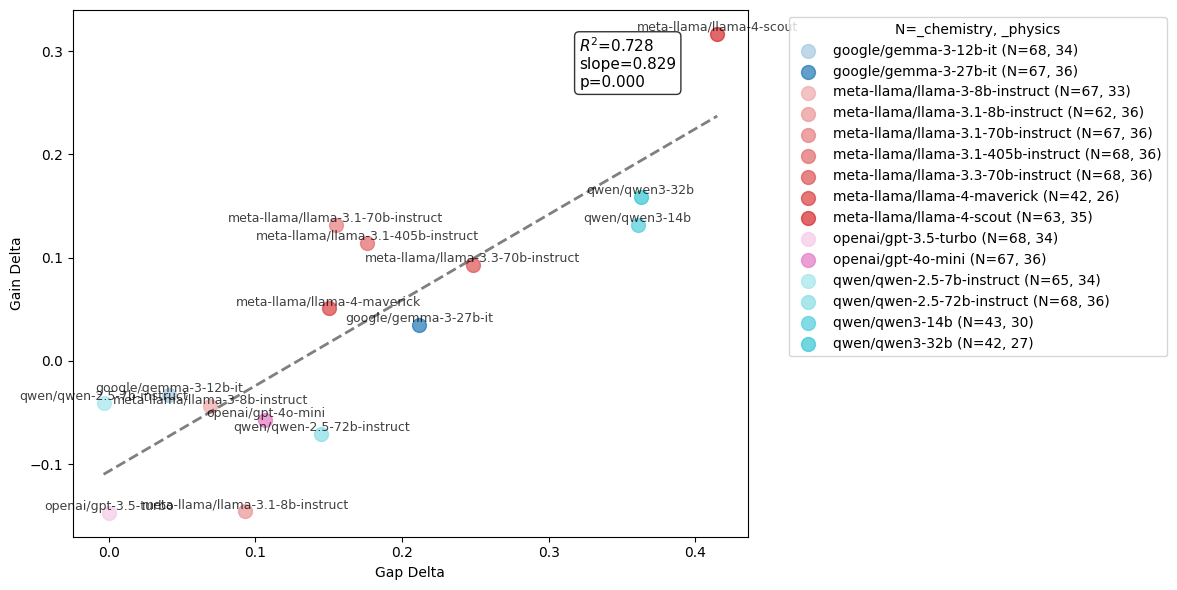

In [12]:
suffixes = ['_chemistry', '_physics']
merged_domains = chemistry_gpqa_acc.merge(physics_gpqa_acc, on='name', suffixes=suffixes)

plot_delta_over_delta(merged_domains, suffixes, xfield='gap_delta', yfield='gain_delta', n_min=20)

### Count reasoning tokens

<Axes: >

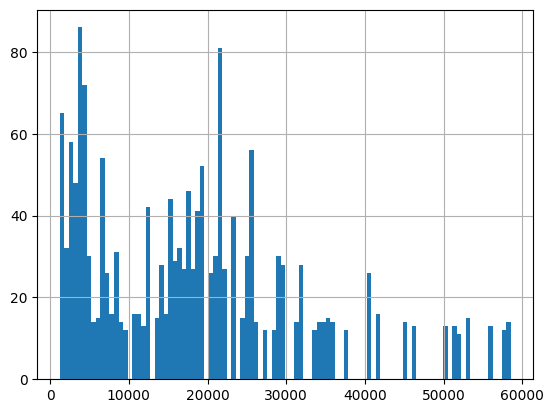

In [13]:
df_4_choice_gpqa['debate_history_debates'].apply(lambda x: sum_reasoning_tokens_over_turns(x)).hist(bins=100)

In [14]:
df_4_choice_gpqa['judge_reasoning_tokens'] = df_4_choice_gpqa['judge_verdict_verdicts'].apply(lambda x: get_reasoning_tokens(x))
df_4_choice_gpqa.groupby('config_judge_model_verdicts')['judge_reasoning_tokens'].sum()

/var/folders/9l/xmd1jn1s1gg47vfyv_n8g3xh0000gn/T/ipykernel_84161/2587502438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4_choice_gpqa['judge_reasoning_tokens'] = df_4_choice_gpqa['judge_verdict_verdicts'].apply(lambda x: get_reasoning_tokens(x))


config_judge_model_verdicts
google/gemma-3-12b-it                     0
google/gemma-3-27b-it                     0
meta-llama/llama-3-8b-instruct            0
meta-llama/llama-3.1-405b-instruct        0
meta-llama/llama-3.1-70b-instruct         0
meta-llama/llama-3.1-8b-instruct          0
meta-llama/llama-3.3-70b-instruct         0
meta-llama/llama-4-maverick               0
meta-llama/llama-4-scout                  0
openai/gpt-3.5-turbo                      0
openai/gpt-4o-mini                        0
qwen/qwen-2.5-72b-instruct                0
qwen/qwen-2.5-7b-instruct                 0
qwen/qwen3-14b                            0
qwen/qwen3-235b-a22b                      0
qwen/qwen3-32b                        20536
qwen/qwen3-8b                             0
Name: judge_reasoning_tokens, dtype: int64